In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys  

#extraction and npl
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.cluster import KMeans

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


#forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#bagging
from sklearn.ensemble import BaggingClassifier
#forests
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification

#Knn
from sklearn.neighbors import KNeighborsClassifier



from sklearn.preprocessing import LabelEncoder


from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn import datasets

import string

from sklearn.decomposition import PCA

from sklearn.naive_bayes import MultinomialNB

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

#  I scraped data in another workbook 
I scraped Indeed.com 
The search terms are my degrees. I only search my geographical region

In [2]:
#importing the CSV file with the data from Indeed
listingFile =pd.read_csv("Listings7.csv",encoding='utf-8')

In [3]:
listingFile.shape

(4390, 8)

In [4]:
listingFile.head(1)

,Unnamed: 0,City Location,Company Name,Degree,Description,Job Title,Search Criteria,Source
0,0,"Cincinnati, OH","Pro4ia, Inc.",user+support,Day-to-day desktop support. Input all service ...,Level 1/2 Desktop Support,user+support,Indeed


In [5]:
#Richard tried this.  You will see at the end when we tried unstructured clustering. It
#was a disaster so he thought there might be some foreign language listings. Not so.  I tried to 
#remove words (see below). Also did not work
from guess_language import guessLanguage

In [6]:
listingFile['english']=listingFile['Description'].apply(lambda x: guessLanguage(x))

In [7]:
listingFile['english'].value_counts()

en     4198
fr       91
ca       39
la       16
af        9
da        9
it        6
de        5
nb        4
pt        4
es        3
nl        2
ro        2
sv        1
ceb       1
Name: english, dtype: int64

In [8]:
listingFile['Degree'].value_counts()

software+development    928
user+support            899
network+manager         872
web+development         864
network+engineer        552
cyber+security          275
Name: Degree, dtype: int64

# Data Cleaning

In [9]:
#now make all words in description lower case
listingFile['CleanDescription']=listingFile['Description'].apply(lambda x: x.lower())

In [10]:
#removing numbers
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

In [11]:
#remove punctuation - code could be more efficient
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.strip(','))
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.strip('.'))
#listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('\('))



In [12]:
#removing numbers from the descriptions
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.lstrip().replace('\n',''))

In [13]:
#checking to see if any null characters
listingFile.isnull().sum()

Unnamed: 0          0
City Location       0
Company Name        0
Degree              0
Description         0
Job Title           0
Search Criteria     0
Source              0
english             0
CleanDescription    0
dtype: int64

In [14]:
#drop duplicates
print listingFile.shape
listingFile=listingFile.drop_duplicates()
print listingFile.shape

(4390, 10)
(4390, 10)


In [15]:
# Removing certain words to see if this will improve my clustering. It did not.

In [16]:
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('development',''))

In [17]:
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('manager',''))

In [18]:
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('*',''))

In [19]:

# listingFile['CleanDescription']=listingFile['CleanDescription'].apply(lambda x: x.strip('development'))

In [20]:
# listingFile['CleanDescription']=listingFile['CleanDescription'].apply(lambda x: x.strip('manager'))

In [21]:
listingFile['CleanDescription'].head(30)

0     day-to-day desktop support. input all service ...
1     is seeking a yardi voyager support specialist....
2     knowledge/experience supporting mobile users. ...
3     produce detailed specifications for software r...
4     software  and hardware integration experience....
5     advanced html/css  (responsive design/mobile f...
6     we are looking for a front-end web designer/de...
7     blue laser design is actively looking to add a...
8      of enterprise web . applications • database d...
9     advanced or formal training in network technol...
10    network services . support and develop corpora...
11    as head of ops tech network engineering, you w...
12    field network engineer. integrate with other s...
13    due to our rapid growth, lang company is looki...
14    assists in the , implementation and maintenanc...
15    apply knowledge of latest cyber security indus...
16    ability to obtain and maintain a secret securi...
17    the network information security analyst w

# looking at degrees and graduates

In [22]:
#creating a table of actual degrees and certificates the college awarded per degree
#this is public information and was manually entered
#degree included short term certificates
tempFile =listingFile.groupby('Degree').count()
tempFile=pd.DataFrame(tempFile['Unnamed: 0'])
tempFile.reset_index(inplace=True)

collegeDegreesVSJobs=pd.DataFrame({'DegreeArea': ['user+support', 'software+development', 
                         'web+development', 'network+manager', 'network+engineer', 
                         'cyber+security'],'Number of': [30,71,31,77,79,8]})
collegeDegreesVSJobs.columns=[['Degree', 'Number of Grads']]
collegeDF= pd.merge(collegeDegreesVSJobs, tempFile, on='Degree')
collegeDF.columns=[['Degree', 'Number of Grads', 'Number Listings']]
collegeDF['pctGradsToListing']=collegeDF['Number of Grads']/collegeDF['Number Listings']
collegeDF

,Degree,Number of Grads,Number Listings,pctGradsToListing
0,user+support,30,899,0.033370
1,software+development,71,928,0.076509
2,web+development,31,864,0.035880
3,network+manager,77,872,0.088303
4,network+engineer,79,552,0.143116
5,cyber+security,8,275,0.029091


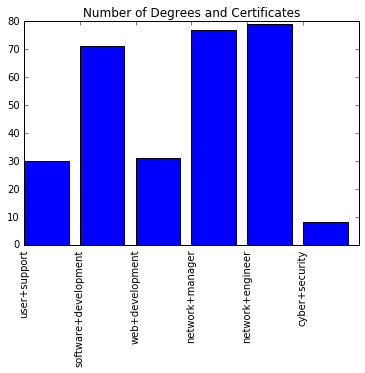

In [23]:
#bar chart
yCollege=collegeDF['Number of Grads']
xCollege=collegeDF['Degree']
plt.bar(range(0, len(xCollege)) ,yCollege)
labels=['user+support', 'software+development', 
                         'web+development', 'network+manager', 'network+engineer', 
                         'cyber+security']

plt.xticks(range(6), labels, rotation='vertical')
plt.title('Number of Degrees and Certificates');



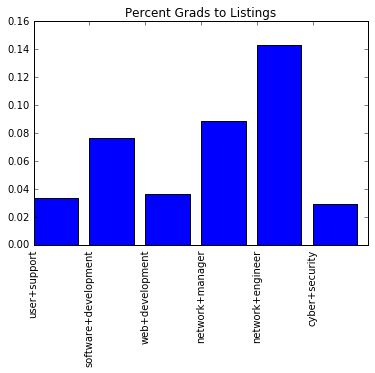

In [24]:
#bar chart
yCollege=collegeDF['pctGradsToListing']
xCollege=collegeDF['Degree']
plt.bar(range(0, len(xCollege)) ,yCollege)
labels=['user+support', 'software+development', 
                         'web+development', 'network+manager', 'network+engineer', 
                         'cyber+security']

plt.xticks(range(6), labels, rotation='vertical')
plt.title('Percent Grads to Listings');

# this is where I would add stemmers lammers
talk with Richard  not enough time!

# Label encoder for degrees

In [25]:
label_encoder = preprocessing.LabelEncoder()
input_classes = ['user+support', 'software+development', 'web+development', 'network+manager',
        'network+engineer', 'cyber+security']
label_encoder.fit(input_classes)


LabelEncoder()

In [26]:
encoded_labels = label_encoder.transform(input_classes)
print "\nLabels =", input_classes 
print "Encoded labels =", list(encoded_labels)


Labels = ['user+support', 'software+development', 'web+development', 'network+manager', 'network+engineer', 'cyber+security']
Encoded labels = [4, 3, 5, 2, 1, 0]


In [27]:
#creating a column for encoded degree
listingFile['encodedDegree']=label_encoder.transform(listingFile['Degree'])

# count vectorizer of the cleanDescription

In [28]:
# will not limit the number of words
cvec = CountVectorizer()
v = CountVectorizer(
    binary=True,  
    stop_words='english')
#,max_features=500


In [29]:
wordsDescription = v.fit_transform(listingFile['CleanDescription']).todense()
wordsDescription = pd.DataFrame(wordsDescription, columns=v.get_feature_names())
wordsDescription.shape

(4390, 5552)

In [30]:
wordsDescription.head(1)

,_adaptive,_care,aam,aarp,abb,abbott,abc,abide,abilities,ability,...,yes,young,youth,yp,yrs,yslow,zero,zone,zoning,zycron
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# create dummies from the degree to see if words can predict degree

In [31]:
degreeDummies=pd.get_dummies(listingFile['Degree'])
wordDescDegree=pd.DataFrame(wordsDescription).join(pd.DataFrame(degreeDummies))
wordDescDegree.head(1)

,_adaptive,_care,aam,aarp,abb,abbott,abc,abide,abilities,ability,...,zero,zone,zoning,zycron,cyber+security,network+engineer,network+manager,software+development,user+support,web+development
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
allDegreeData=pd.DataFrame(listingFile['encodedDegree']).join(pd.DataFrame(listingFile['Degree'])).join(pd.DataFrame(degreeDummies))

In [33]:
allDegreeData.head(1)

,encodedDegree,Degree,cyber+security,network+engineer,network+manager,software+development,user+support,web+development
0,4,user+support,0.0,0.0,0.0,0.0,1.0,0.0


# create train test

In [34]:
wordsDescription.shape , listingFile['encodedDegree'].shape

((4390, 5552), (4390,))

## setting the x and y

In [35]:
x=wordsDescription
y=listingFile['encodedDegree']

In [36]:
x_train, x_test, y_train, y_test= train_test_split(x.values,y.values, test_size=.4, stratify=y )

In [37]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2633, 5552), (1757, 5552), (2633,), (1757,))

# creating dimension reduction PCA on Train Dataset

In [38]:
# I tried a series of components  decided on 5

In [39]:
pca=PCA(n_components=5)
pca.fit(x_train)
pca.fit_transform(x_train)

array([[ 0.20958142, -0.18648531,  0.67390974, -0.63555002,  0.07270982],
       [ 0.17374592, -0.19757503,  0.52075029, -0.50487833,  0.23389339],
       [-0.29421481, -0.11002042,  0.09568819, -0.26575917, -0.48507871],
       ..., 
       [-0.02858219, -0.25012087, -0.01445554, -0.36597287,  0.01764085],
       [-0.22521445,  0.15661947,  0.13678231, -0.33420616, -0.22099934],
       [-0.71920661,  0.60359217,  0.17439366,  0.05287688, -0.19006315]])

In [40]:
pca.get_covariance()

array([[  4.08482087e-03,  -3.66588885e-07,  -1.83563699e-07, ...,
          0.00000000e+00,  -2.84784820e-08,  -4.21184139e-07],
       [ -3.66588885e-07,   4.08226463e-03,  -1.94140445e-07, ...,
          0.00000000e+00,  -8.15437526e-08,   5.34092656e-07],
       [ -1.83563699e-07,  -1.94140445e-07,   4.08174475e-03, ...,
          0.00000000e+00,   1.15291299e-07,  -5.39841092e-08],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          4.08150855e-03,   0.00000000e+00,   0.00000000e+00],
       [ -2.84784820e-08,  -8.15437526e-08,   1.15291299e-07, ...,
          0.00000000e+00,   4.08164044e-03,   7.13076931e-08],
       [ -4.21184139e-07,   5.34092656e-07,  -5.39841092e-08, ...,
          0.00000000e+00,   7.13076931e-08,   4.08213514e-03]])

In [41]:
pca.explained_variance_

array([ 0.30413065,  0.23598596,  0.19113964,  0.1591685 ,  0.12363231])

In [42]:
np.cumsum(pca.explained_variance_)

array([ 0.30413065,  0.54011661,  0.73125625,  0.89042475,  1.01405706])

In [43]:
train_features=pca.fit_transform(x_train)

In [44]:
train_features.shape

(2633, 5)

# lets try random forest with full dataset and pca

1. using full data set without train test.  I am only doing this to get a list of words for each degree
2. using PCA  I did this to see if this predicts my degrees

In [45]:
#full dataset 
y=LabelEncoder().fit_transform(listingFile['Degree'])
cv = StratifiedKFold(y, n_folds=4, shuffle=True, random_state=41)
print type(y), y[0:6]
print type(x)

<type 'numpy.ndarray'> [4 4 4 3 3 3]
<class 'pandas.core.frame.DataFrame'>


In [46]:
x.shape, y.shape


((4390, 5552), (4390,))

In [47]:
rf=RandomForestClassifier(class_weight ='balanced', n_jobs=-1)
s=cross_val_score(rf,x.values,y,cv=cv, n_jobs=-1)


In [48]:
s

array([ 0.76867031,  0.79143898,  0.77504554,  0.7399635 ])

In [49]:
rf.fit(x, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [50]:
#nice score of course it includes all data!
rf.score(x, y)

0.97517084282460131

In [51]:
# for f in range(x.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

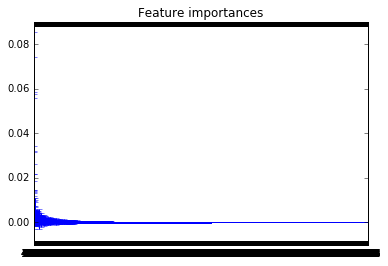

In [52]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [53]:
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [54]:
#this is what I want to see
feature_importancesRF.head(10)

,importance
security,0.055859
web,0.044164
software,0.040000
support,0.038529
network,0.035976
engineer,0.022892
user,0.017778
users,0.017773
implementation,0.009286
engineers,0.008150


In [55]:
predictionsRF=rf.predict(x)

In [56]:
print confusion_matrix(y, predictionsRF)

[[274   0   0   0   0   1]
 [  2 536  10   3   1   0]
 [  0  14 854   3   0   1]
 [  1   3   0 894   2  28]
 [  1   0   2   0 896   0]
 [  0   2   6  28   1 827]]


In [57]:
#this chart is very meaningfull miss-predictions show overlap of degrees
conmat = np.array(confusion_matrix(y, predictionsRF))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion


      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU        274          0          0          0          0          1
SODE          2        536         10          3          1          0
WEDE          0         14        854          3          0          1
NEMA          1          3          0        894          2         28
NEED          1          0          2          0        896          0
CYIT          0          2          6         28          1        827


In [58]:
print  classification_report(y, predictionsRF)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       275
          1       0.97      0.97      0.97       552
          2       0.98      0.98      0.98       872
          3       0.96      0.96      0.96       928
          4       1.00      1.00      1.00       899
          5       0.96      0.96      0.96       864

avg / total       0.98      0.98      0.98      4390



# random forest by degree - want feature importance
this will help me understand the job market

In [59]:
wordDescDegree.columns

Index([u'_adaptive', u'_care', u'aam', u'aarp', u'abb', u'abbott', u'abc',
       u'abide', u'abilities', u'ability',
       ...
       u'zero', u'zone', u'zoning', u'zycron', u'cyber+security',
       u'network+engineer', u'network+manager', u'software+development',
       u'user+support', u'web+development'],
      dtype='object', length=5558)

In [60]:
yCYIT=wordDescDegree['cyber+security']
yNEEN=wordDescDegree['network+engineer']
yNEMA=wordDescDegree['network+manager']
ySODE=wordDescDegree['software+development']
yUSSU=wordDescDegree['user+support']
yWEDE=wordDescDegree['web+development']

In [61]:
yDegree=yCYIT
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(20)

0.997038724374
              importance
security        0.112529
cyber           0.094642
software        0.033880
information     0.019154
clearance       0.016480
support         0.014560
web             0.013507
risk            0.013407
united          0.010320
secret          0.009838
technology      0.008711
intelligence    0.008235
analyst         0.008155
job             0.007742
users           0.007383
network         0.007244
fastest         0.007179
user            0.006863
strategic       0.006601
description     0.005953


In [62]:
yDegree=yNEEN
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(30)

0.98861047836
                 importance
engineer           0.080127
network            0.063944
implementation     0.037229
engineers          0.036592
networks           0.024434
web                0.021199
software           0.015029
user               0.007493
troubleshooting    0.006489
support            0.006450
communication      0.006154
experience         0.005866
infrastructure     0.005549
cisco              0.005210
electrical         0.005059
systems            0.004806
storage            0.004643
ip                 0.004639
reports            0.004357
local              0.004240
users              0.004102
integration        0.004041
seeking            0.003630
technical          0.003470
ge                 0.003351
understanding      0.003214
end                0.003090
layers             0.002999
manufacturing      0.002834
practicality       0.002762


In [63]:
yDegree=yNEMA
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(30)

0.990432801822
                importance
network           0.062332
software          0.051917
web               0.039827
user              0.033019
engineer          0.018618
experience        0.017612
design            0.017070
users             0.017003
support           0.013483
security          0.011067
networks          0.010794
application       0.010441
reports           0.007689
account           0.006902
engineers         0.006838
implementation    0.005927
test              0.005681
cyber             0.005660
systems           0.005556
relationships     0.005490
case              0.005183
sales             0.004389
end               0.004367
project           0.004336
java              0.004071
technical         0.003728
lifecycle         0.003710
regional          0.003284
years             0.003179
understanding     0.003060


In [64]:
yDegree=ySODE
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(30)

0.980637813212
              importance
software        0.126886
network         0.067460
web             0.025591
support         0.024593
user            0.012989
security        0.012582
users           0.011577
experience      0.011165
networks        0.008725
design          0.007817
cycle           0.007721
testing         0.007327
agile           0.006144
lifecycle       0.006093
developer       0.005415
hardware        0.005094
test            0.004873
end             0.004873
years           0.004713
services        0.004180
using           0.003922
knowledge       0.003810
provide         0.003543
engineering     0.003495
applications    0.003372
systems         0.003308
use             0.003283
application     0.003189
cyber           0.002998
business        0.002916


In [65]:
yDegree=yUSSU
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(20)

0.997949886105
            importance
support       0.151998
user          0.115573
users         0.059059
network       0.029467
software      0.019354
web           0.019249
provide       0.014997
end           0.013186
supports      0.010444
engineer      0.009049
providing     0.006931
networks      0.006425
business      0.006303
experience    0.006294
engineers     0.005824
analyst       0.005732
desktop       0.005216
cycle         0.004628
provides      0.004450
customer      0.004240


In [66]:
yDegree=yWEDE
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(20)

0.981093394077
              importance
web             0.114242
network         0.028011
experience      0.026395
support         0.014156
application     0.011492
user            0.010387
security        0.009987
services        0.009935
users           0.009690
applications    0.009657
systems         0.008094
hardware        0.007429
content         0.006591
java            0.006223
mobile          0.005773
networks        0.005765
javascript      0.005698
software        0.005230
using           0.004917
engineer        0.004445


# Random Forest on  train test

In [67]:
train_features=pca.fit_transform(x_train)

In [68]:
x_train.shape, train_features.shape,y_train.shape


((2633, 5552), (2633, 5), (2633,))

In [69]:
rfTTS=RandomForestClassifier(class_weight ='balanced', n_jobs=-1)


In [70]:
listingFile.ix[2634]

Unnamed: 0                                                       2788
City Location                                          Cincinnati, OH
Company Name                                              Zones, Inc.
Degree                                                web+development
Description         \nWeb & Email Gateways. The design of your sol...
Job Title           Solutions Architect, Networking Infrastructure...
Search Criteria                                       web+development
Source                                                         Indeed
english                                                            en
CleanDescription    web & email gateways. the design of your solut...
encodedDegree                                                       5
Name: 2634, dtype: object

In [71]:
cv = StratifiedKFold(y_train, n_folds=4, shuffle=True, random_state=41)
# print type(y), y[0:6]
# print type(x)

In [72]:
sTTS=cross_val_score(rfTTS,train_features,y_train,cv=cv, n_jobs=-1)

In [73]:
# s

In [74]:
rfTTS.fit(train_features, y_train)
importances = rfTTS.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [75]:
rfTTS.score(train_features, y_train)

0.97303456133687805

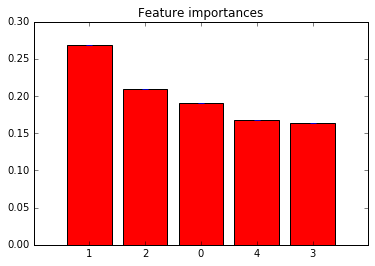

In [76]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), indices)
plt.xlim([-1, train_features.shape[1]])
plt.show()

# RF model built with PCA test data

In [77]:
train_features.shape, x_test.shape


((2633, 5), (1757, 5552))

In [78]:
test_features=pca.transform(x_test)

In [79]:
rfTTS.score(test_features, y_test)

0.73705179282868527

In [80]:
predictionsRF_test=rfTTS.predict(test_features)

In [81]:
y_test.shape, predictionsRF_test.shape

((1757,), (1757,))

In [82]:
print confusion_matrix(y_test, predictionsRF_test)

[[ 80   8  13   3   5   1]
 [  6 132  53  14  11   5]
 [  5  66 237   9  19  13]
 [  1   6  20 294  15  35]
 [  3   6   8  14 322   7]
 [  4   8  29  61  14 230]]


In [83]:
#this matrix is very telling
conmat = np.array(confusion_matrix(y_test, predictionsRF_test))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion

      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU         80          8         13          3          5          1
SODE          6        132         53         14         11          5
WEDE          5         66        237          9         19         13
NEMA          1          6         20        294         15         35
NEED          3          6          8         14        322          7
CYIT          4          8         29         61         14        230


# K nearest neighbors entire dataset - first


In [84]:
x=wordsDescription

In [85]:
y=listingFile['encodedDegree']
y.column='degree'

In [86]:
knn=KNeighborsClassifier(n_neighbors=5)
#5 closest neighbors

In [87]:
knn.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [88]:
knn.score(x,y)

0.76036446469248287

In [89]:
scores=cross_val_score(knn,x.values,y,cv=5,scoring = 'accuracy')

In [90]:
predictionsKNN=knn.predict(x)

In [91]:
print confusion_matrix(y, predictionsKNN)

[[239   7  10  13   1   5]
 [ 25 369  71  71  10   6]
 [ 16  42 751  35   8  20]
 [  4   2  24 852   5  41]
 [ 23  11 110 169 567  19]
 [ 14   5  53 224   8 560]]


In [92]:
conmat = np.array(confusion_matrix(y, predictionsKNN))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion

      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU        239          7         10         13          1          5
SODE         25        369         71         71         10          6
WEDE         16         42        751         35          8         20
NEMA          4          2         24        852          5         41
NEED         23         11        110        169        567         19
CYIT         14          5         53        224          8        560


In [93]:
print  classification_report(y, predictionsKNN)

             precision    recall  f1-score   support

          0       0.74      0.87      0.80       275
          1       0.85      0.67      0.75       552
          2       0.74      0.86      0.79       872
          3       0.62      0.92      0.74       928
          4       0.95      0.63      0.76       899
          5       0.86      0.65      0.74       864

avg / total       0.79      0.76      0.76      4390



# Knn on PCA training set 

In [94]:
knnTTS=KNeighborsClassifier(n_neighbors=5)

In [95]:
knnTTS.fit(train_features,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [96]:
knnTTS.score(train_features,y_train)

0.79111279908849219

In [97]:
predictionsKNN=knnTTS.predict(train_features)

In [98]:
print confusion_matrix(y_train, predictionsKNN)

[[110  11  22   5   9   8]
 [ 12 218  77  13   4   7]
 [ 10  46 435   8  12  12]
 [  5  11  28 448  18  47]
 [  4   8  18  23 480   6]
 [  6  10  30  60  20 392]]


# Knn on test data after being trained on training data

In [99]:
test_featuresKNN_TTS=pca.transform(x_test)

In [100]:
knnTTS.score(test_featuresKNN_TTS,y_test)

0.73648264086511095

In [101]:
predictionsKNN_TTS=knnTTS.predict(test_featuresKNN_TTS)

In [102]:
print confusion_matrix(y_test, predictionsKNN_TTS)

[[ 82   7  12   4   3   2]
 [  8 120  69  12   9   3]
 [  4  44 270   8  14   9]
 [  1  11  24 294  15  26]
 [  4  12  11  24 304   5]
 [  4  10  34  56  18 224]]


In [103]:
conmat = np.array(confusion_matrix(y_test, predictionsKNN_TTS))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion

      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU         82          7         12          4          3          2
SODE          8        120         69         12          9          3
WEDE          4         44        270          8         14          9
NEMA          1         11         24        294         15         26
NEED          4         12         11         24        304          5
CYIT          4         10         34         56         18        224


# Naive Bayes for clustering not going to use

In [104]:
mnb=MultinomialNB()

In [105]:
mnb.fit(x,y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [106]:
mnb.score(x,y)

0.87175398633257406

In [107]:
y_hat=mnb.predict(x)

In [108]:
print classification_report(y, y_hat)

             precision    recall  f1-score   support

          0       0.92      0.85      0.88       275
          1       0.85      0.86      0.86       552
          2       0.91      0.86      0.88       872
          3       0.83      0.87      0.85       928
          4       0.87      0.96      0.91       899
          5       0.88      0.82      0.85       864

avg / total       0.87      0.87      0.87      4390



In [109]:
confusion_matrix(y,y_hat)

array([[233,  11,   5,   8,  10,   8],
       [  5, 475,  25,  25,  18,   4],
       [  5,  57, 747,  18,  34,  11],
       [  4,   6,  13, 806,  36,  63],
       [  1,   5,   7,  15, 861,  10],
       [  6,   5,  21,  98,  29, 705]])

In [110]:
predicted_probabilities=mnb.predict_proba(x)
predicted_probabilities[0:5]

array([[  6.14364497e-08,   8.54431458e-07,   2.80123165e-04,
          2.42797263e-07,   9.99712438e-01,   6.27971586e-06],
       [  1.67003867e-06,   4.27528885e-06,   2.34279916e-06,
          1.20358367e-06,   9.99990477e-01,   3.09474982e-08],
       [  2.09176733e-09,   1.41954694e-06,   5.73284086e-07,
          2.97047222e-08,   9.99996145e-01,   1.83059203e-06],
       [  4.73303420e-07,   5.27727447e-04,   2.54797621e-06,
          9.95878352e-01,   3.58429684e-03,   6.60218636e-06],
       [  1.72846279e-07,   1.20771876e-03,   1.03562591e-06,
          9.98605078e-01,   9.08423865e-06,   1.76910758e-04]])

# K means

In [111]:
#standarizing x  Richard made me do this. I liked my results from the non-transformed data
#but he said for KMeans the data needs to be transformed
#everything clustered together in to one cluster
# I think when I enter data from job description I will be able to use this
standardizedFeatures=StandardScaler().fit_transform(wordsDescription)

In [112]:
kmeans=KMeans(6)
kmeans.fit(standardizedFeatures)
predicts=kmeans.predict(standardizedFeatures)

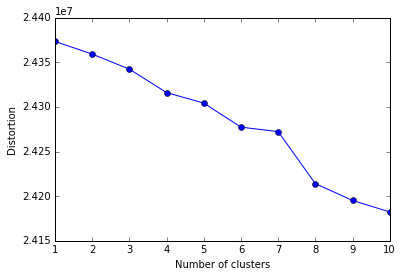

In [113]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(standardizedFeatures)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [114]:
df = pd.DataFrame(standardizedFeatures, columns=wordsDescription.columns)

# df.development.describe()
# df.head()

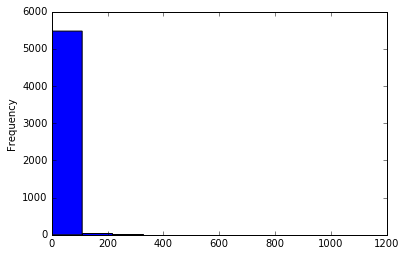

In [115]:
wordsDescription.sum().sort_values().plot(kind='hist')

In [116]:

type(listingFile)

pandas.core.frame.DataFrame

In [117]:
df.shape

(4390, 5552)

In [118]:
df = listingFile.join(pd.DataFrame(kmeans.predict(standardizedFeatures), 
                 columns=['with standardized wordsDescription']))

In [119]:
df.tail()

,Unnamed: 0,City Location,Company Name,Degree,Description,Job Title,Search Criteria,Source,english,CleanDescription,encodedDegree,with standardized wordsDescription
4385,5990,"Covington, KY","Pro Mach, Inc.",network+manager,\nCorporate Audit Manager - Job Description:. ...,Corporate Audit Manager,network+manager,Indeed,en,corporate audit - job description:. strong in...,2,0
4386,5991,"Dayton, OH",Kettering Health Network,network+manager,\nReports directly to the Administrative Direc...,PHYSICAL THERAPIST,network+manager,Indeed,en,reports directly to the administrative directo...,2,0
4387,5992,"Columbus, OH",Huntington,network+manager,\nCompliance Group Manager - Deposit Products ...,Compliance Group Manager - Deposit Products & ...,network+manager,Indeed,en,compliance group - deposit products & busines...,2,0
4388,5993,"Springfield, OH",AMERICAN CANCER SOCIETY,network+manager,\nCollaborate with Hospital Account Manager to...,Patient Navigator,network+manager,Indeed,en,collaborate with hospital account to develop ...,2,0
4389,5994,"Columbus, OH",Molina Healthcare,network+manager,\nCertified Case Manager (CCM). RNs provide co...,Case Manager (RN),network+manager,Indeed,en,certified case (ccm). rns provide consultatio...,2,0


In [120]:
# resultsOFClustering=df[['Degree','Search Criteria','encodedDegree','predictions_k6']]

In [121]:
#resultsOFClustering.head(1)

In [122]:
# for n_clusters in range(0,6):
#     fig, (ax1, ax2)=plt.subplots(1,2)
#     fig.set_size_inches(18,7)

In [123]:
clusterer = AgglomerativeClustering(n_clusters=2)
cluster_labels = clusterer.fit_predict(standardizedFeatures)

In [124]:
#new_df = listingFile.join(pd.DataFrame(cluster_labels, columns=['labels']))
#new_df.loc[(new_df['labels'] == 1), 'CleanDescription'].values # to see the actual description
#new_df.loc[(new_df['labels'] == 1)]

In [125]:
#new_df.tail()

('For n_clusters =', 2, 'The average silhouette_score is :', 0.57654355866850082)


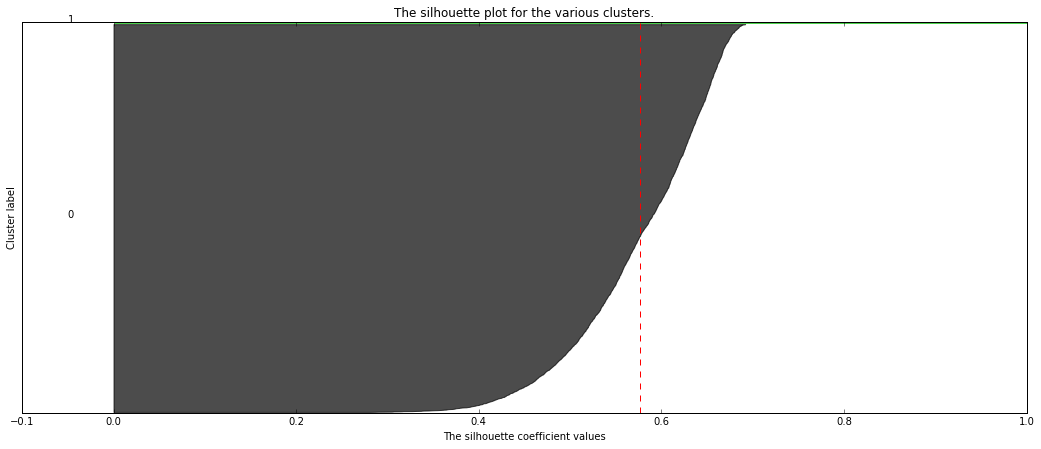

('For n_clusters =', 3, 'The average silhouette_score is :', 0.54453830704757156)


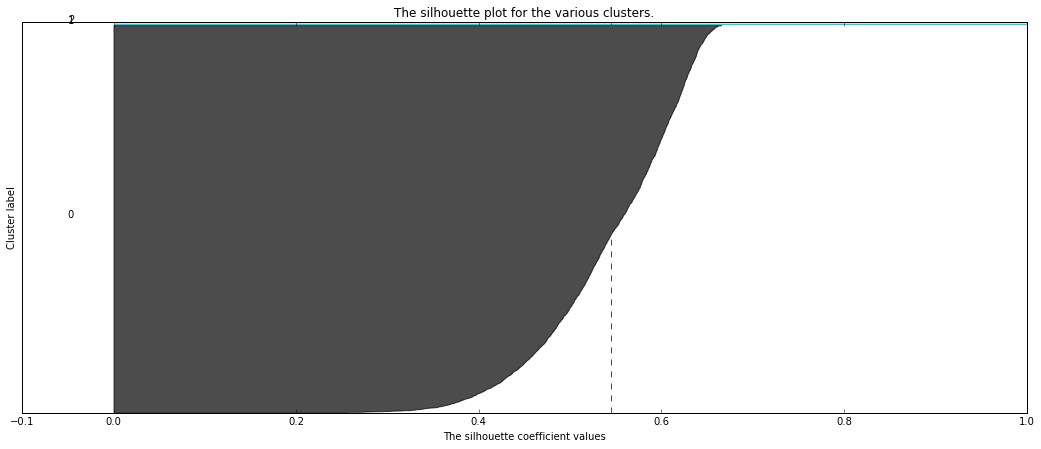

('For n_clusters =', 4, 'The average silhouette_score is :', 0.53759138458220057)


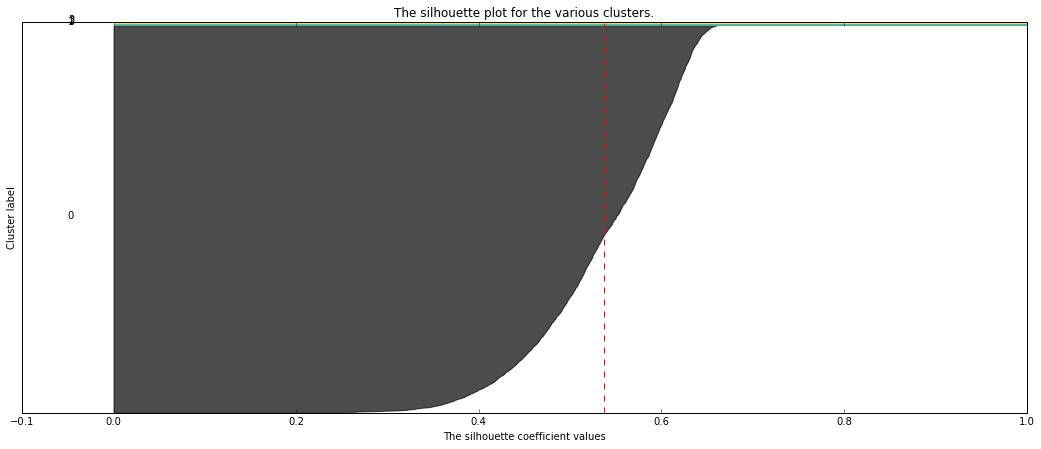

In [126]:
# from sklearn.cluster import AgglomerativeClustering

range_n_clusters = range(2, 5)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(standardizedFeatures) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(standardizedFeatures)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(standardizedFeatures, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(standardizedFeatures, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

# without scaler so the following code is worthless - too bad
because I like the results


In [128]:
kmeans=KMeans(6)
kmeans.fit(x)
predicts=kmeans.predict(x)

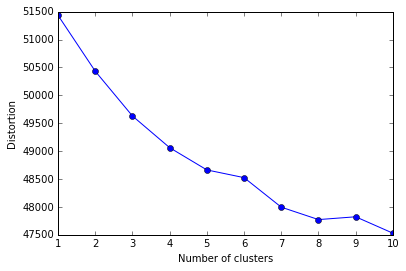

In [129]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [130]:
df = listingFile.join(
    pd.DataFrame(kmeans.predict(x), 
                 columns=['predictions_k6'])
)

In [131]:
df.head()

,Unnamed: 0,City Location,Company Name,Degree,Description,Job Title,Search Criteria,Source,english,CleanDescription,encodedDegree,predictions_k6
0,0,"Cincinnati, OH","Pro4ia, Inc.",user+support,Day-to-day desktop support. Input all service ...,Level 1/2 Desktop Support,user+support,Indeed,en,day-to-day desktop support. input all service ...,4,0
1,1,"Columbus, OH 43215","The Woda Group, Inc.",user+support,", is seeking a *Yardi Voyager Support Speciali...",Yardi Voyager Support Specialist,user+support,Indeed,en,is seeking a yardi voyager support specialist....,4,0
2,2,"Fort Wayne, IN","ENS Group, Inc.",user+support,Knowledge/experience supporting mobile users. ...,Service Desk Technician,user+support,Indeed,fr,knowledge/experience supporting mobile users. ...,4,0
3,12,"Dayton, OH",Riverside Research,software+development,Produce detailed specifications for software r...,Software Developer,software+development,Indeed,en,produce detailed specifications for software r...,3,1
4,13,"Wright-Patterson AFB, OH",Riverside Research,software+development,Software development and hardware integration ...,Software Engineer,software+development,Indeed,en,software and hardware integration experience....,3,1


In [132]:
resultsOFClustering=df[['Degree','Search Criteria','encodedDegree','predictions_k6']]

In [133]:
resultsOFClustering.head(1)

,Degree,Search Criteria,encodedDegree,predictions_k6
0,user+support,user+support,4,0


('For n_clusters =', 4, 'The average silhouette_score is :', 0.016349863103616392)


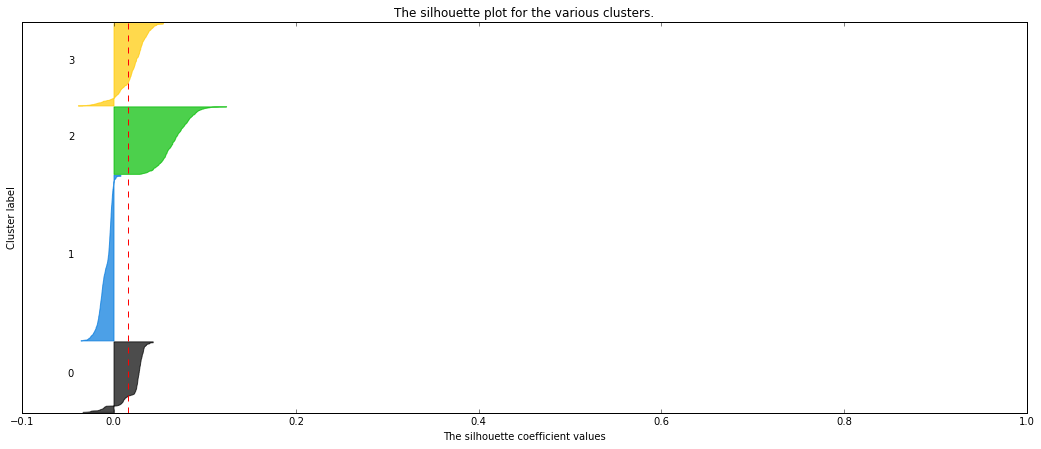

('For n_clusters =', 5, 'The average silhouette_score is :', 0.018410479041044304)


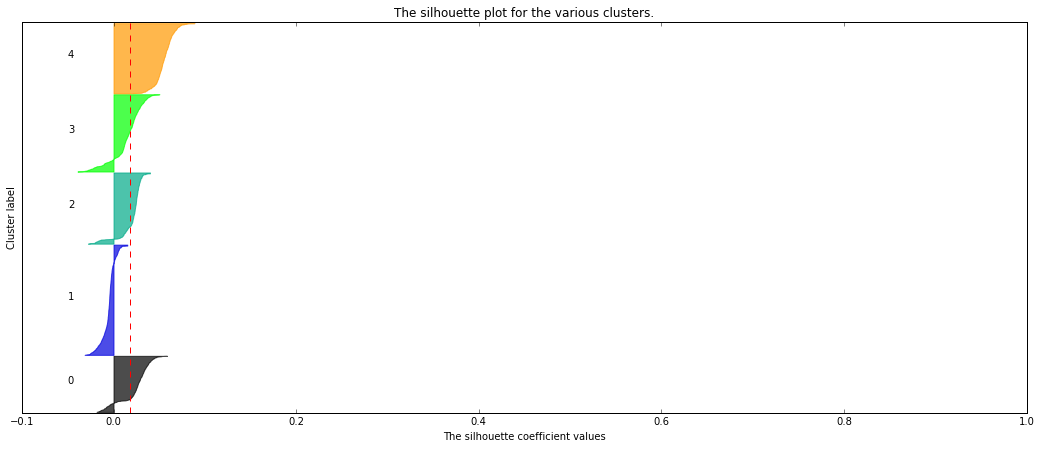

('For n_clusters =', 6, 'The average silhouette_score is :', 0.019061747842804708)


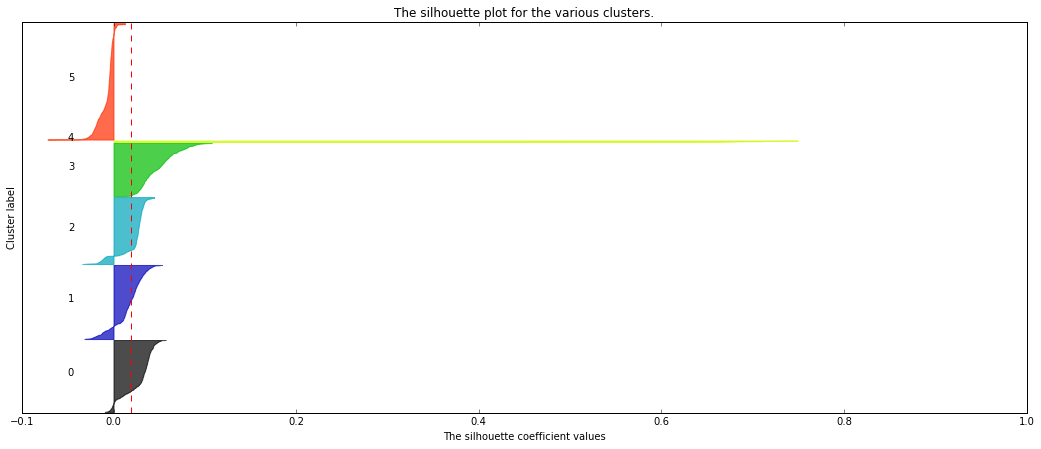

('For n_clusters =', 7, 'The average silhouette_score is :', 0.019773683815561643)


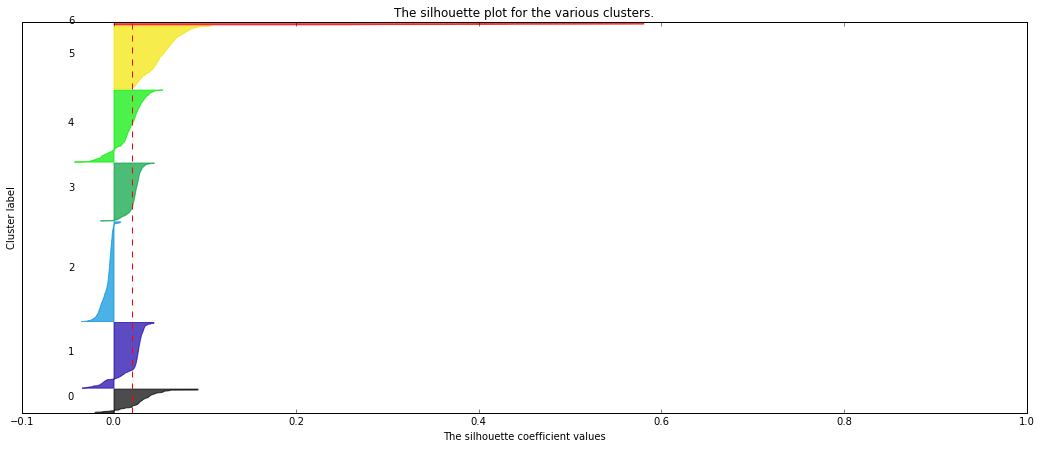

('For n_clusters =', 8, 'The average silhouette_score is :', 0.012580439451854953)


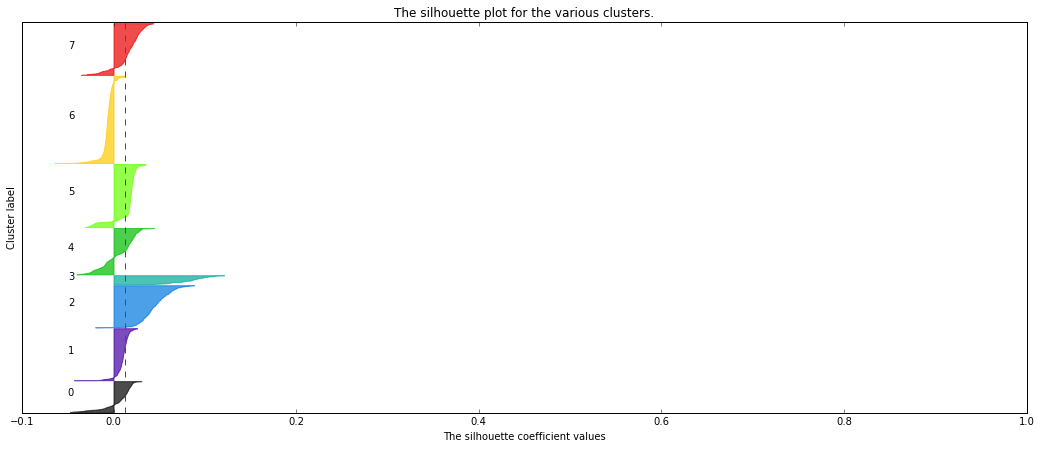

('For n_clusters =', 9, 'The average silhouette_score is :', 0.013146234396470433)


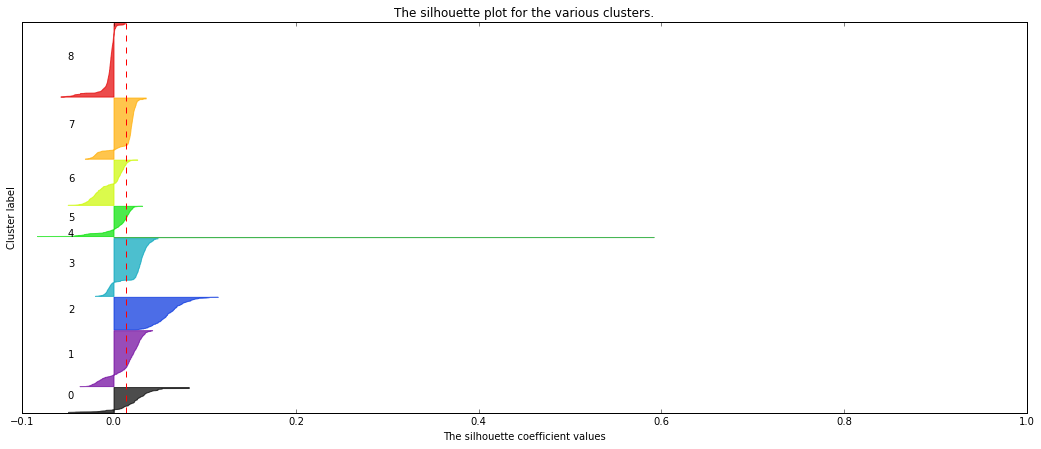

('For n_clusters =', 10, 'The average silhouette_score is :', 0.013322110006263767)


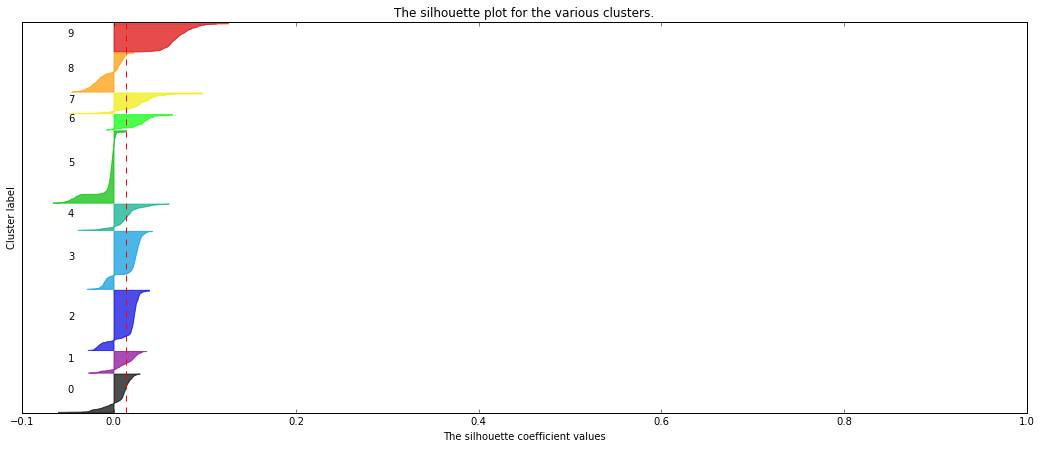

('For n_clusters =', 11, 'The average silhouette_score is :', 0.012502007043009286)


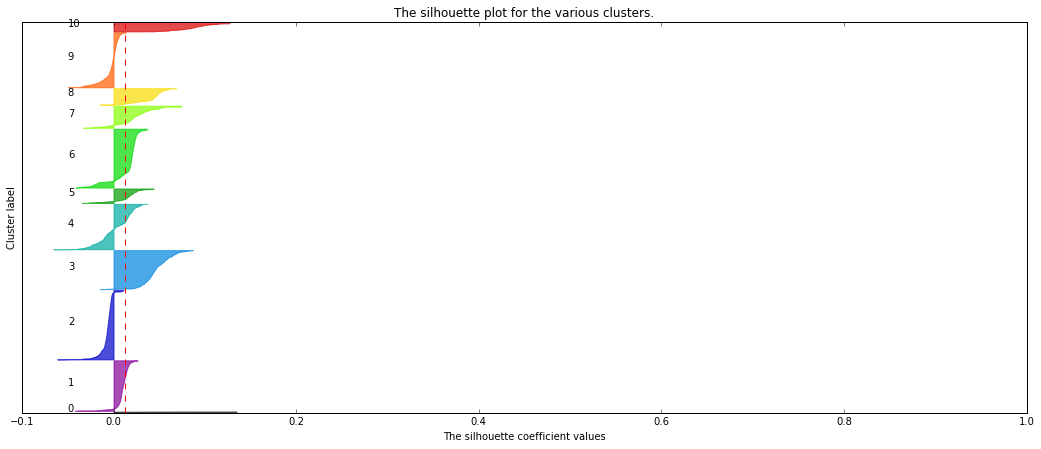

In [134]:
range_n_clusters = range(4, 12)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

# Visualizing the data with TSNE

In [135]:
from sklearn.manifold import TSNE

In [136]:
tsne = TSNE()

In [137]:
graphing_data = tsne.fit_transform(x)

In [138]:
graphing_data[0:5]

array([[ -0.70569078,   4.41075587],
       [ -5.48811839,   4.89968198],
       [ -8.20480846,   3.53602801],
       [ -2.43236473, -10.04377149],
       [ -3.65460777,  -9.19675684]])

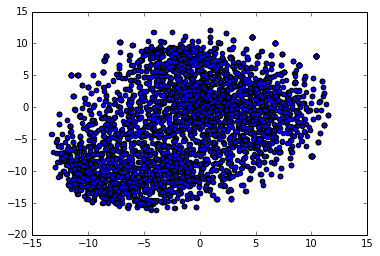

In [139]:
plt.scatter(graphing_data[:,0], graphing_data[:,1])

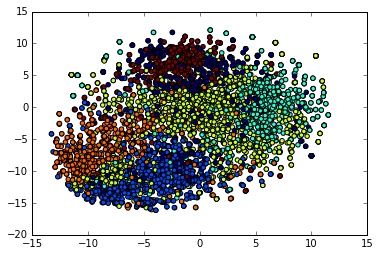

In [140]:
plt.scatter(graphing_data[:,0], graphing_data[:,1],
           c=kmeans.predict(x)) 